In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numpy import pi
from matplotlib.patches import Rectangle
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')

m_u = 1.6605e-27
m_He = 4*m_u
k_B = 1.380649e-23
h = 6.62607015e-34
T = 298
K = 2*np.pi*np.sqrt(5*m_He*k_B*T)/h

## Functions

Function that analyses a pinhole plate.

In [2]:
def pinhole_analysis(alpha, beta, a1, a2, b, Hp, Hd, z_array):
    '''alpha=incidnet angle; 
    beta=detector tilt angle; 
    a1=in-plane width of detector hole; 
    a2=out-of-plane axis of detector hold; 
    b=distance between pinhole and detector hole; 
    Hp=pinhole height; 
    Hd=detector hole height"
    '''
    alpha = alpha/180*np.pi
    beta = beta/180*np.pi
    psi_ip_array = []
    psi_op_array = []
    theta_array = []
    I_array = []
    DK_array = []
    for i in range(len(z_array)):

        z = z_array[i]
        #B = np.abs(b - z*np.tan(alpha))
        B = b - z*np.tan(alpha)
        A_cos = a1/2 * np.cos(beta)
        A_sin = a1/2 * np.sin(beta)
        Z = z + Hp - Hd

        psi_ip = math.atan((B+A_cos)/(Z - A_sin)) - math.atan((B-A_cos)/(Z + A_sin))
        if psi_ip < 0:
            psi_ip = psi_ip + np.pi
        psi_ip_array.append(psi_ip/np.pi*180)

        theta = math.atan(B/Z)
        theta_array.append(theta/np.pi*180)

        psi_op = math.atan((a2/2)/(Z/np.cos(theta)))/np.pi*180*2
        psi_op_array.append(psi_op)

        if b-z*np.tan(alpha) >= 0:
            p = (b-z*np.tan(alpha))*np.cos(beta)-Z*np.sin(beta)
        if b-z*np.tan(alpha) < 0:
            #p = (z*np.tan(alpha)-b)/np.cos(beta)
            p = (z*np.tan(alpha)-b)/np.cos(beta) + (Z - (z*np.tan(alpha)-b)*np.tan(beta))*np.sin(beta)

        h = np.cos(beta)*(Z + (b - z*np.tan(alpha))*np.tan(beta))

        solid_angle =  calc_omega(p,0,h,a1,a2)
        I_array.append(solid_angle)
        DK = K*(np.sin(theta) - np.sin(alpha))
        DK_array.append(DK)
    
    df = pd.DataFrame({'psi_ip' : psi_ip_array,
                       'psi_op' : psi_op_array,
                       'theta' : theta_array,
                       'omega' : I_array,
                       'DK' : np.array(DK_array)*1e-9,
                       'z' : z_array})
    return(df)


Code for calculating the solid angle of an ellipse. 

- $a$ is the first semi-axis, in-plane
- $b$ is the second semi-axis, out-plane
- $p$ is the distance from the centre along the same axis as $a$
- $q$ is the distance from the centre along the same axis as $b$
- $h$ is the perpendicular distance
All are in the same units.


In [3]:


def integrand_general(phi, p, q, h, a, b):# Elliptical solid angle code developed by Sam Lambrick
    """Integrand for the general case from 'John T. Conway' 'Analytic solution
    for the solid angle subtended at a point source radiation vector potential'
    which claims to be general, unlike Abbas et.al. who do not consider the
    case inside the bounding box but outisde the ellipse."""

    tmp = p*p + q*q + h*h + 2*a*p*np.cos(phi) + 2*b*q*np.sin(phi) + \
        (a*np.cos(phi))**2 + (b*np.sin(phi))**2
    term1 = 1 - h/(np.sqrt(tmp))
    tmp = tmp - h*h
    term2 = (a*b + p*b*np.cos(phi) + q*a*np.sin(phi))/(tmp)
    result = term1*term2
    return(result)


def calc_omega(p, q, h, a, b):# Elliptical solid angle code developed by Sam Lambrick
    """Calculates the solid angle using the formula derived by John T. Conway
    2010. Is faster than the alternative integral in 'solid_angle_calc'.

    Inputs:
     p - The distance between the point of interest and the centre of the
         ellipse, projected into the plane of the ellipse along the major axis(in-plane axis).
         Should not be negative.
     q - The distance between the point of interest and the centre of the
         ellipse, projected into the plane of the elllipse along the minor
         axis. Should not be negative
     h - The perpendicular distance between the point of interest and the plane
         of the ellipse. Should not be negative.
     a - The semi-axis(in-plane axis) of the ellipse along which the point of interest lies
         when it is projected into the plane of the ellipse.
     b - The other semi-axis of the ellipse.

    Output:
     omega - The solid angle subtended by the ellipse from the point of
             interest
    """

    omega = integrate.quad(integrand_general, 0, 2*np.pi,
                           args=(p, q, h, a, b,))[0]
    return(omega)


A-SHeM plate:
 - $\alpha=45^\circ$
 - $\beta=0^\circ$
 - $a_1=0.7$ mm
 - $a_2=0.5$ mm
 - $b=5.5$ mm
 - $H_p=5$ mm
 - $H_d=3.5$ mm
 
B-SHeM mixed gas:
 - $\alpha=30^\circ$
 - $\beta=0^\circ$
 - $a_1=0.7$ mm
 - $a_2=1.0$ mm
 - $b=2\sqrt{3}=3.46$ mm
 - $H_p=4.0$ mm
 - $H_d=4.0$ mm

B-SHeM angular proposal:
 - $\alpha=30^\circ$
 - $\beta=10^\circ$
 - $a_1=0.5$ mm
 - $a_2=0.5$ mm
 - $b=\sqrt{3}\frac{8}{3}=4.62$ mm
 - $H_p=4.0$ mm
 - $H_d=4.0$ mm

B-SHeM spatial proposal:
 - $\alpha=30^\circ$
 - $\beta=0^\circ$
 - $a_1=0.5$ mm
 - $a_2=0.5$ mm
 - $b=\sqrt{3}\frac{8}{6}=2.31$ mm
 - $H_p=4.0$ mm
 - $H_d=3.5$ mm

## Create data

For each of the designs calculate $z,\theta,\Delta K$ and both in plane and out of plane angular resolution.

In [4]:
z = np.linspace(1,12,100)

# Old designs
mixed_gas = pinhole_analysis(30, 0, 0.7, 1.0, np.sqrt(3)*2, 4.0, 4.0,z)
a_shem = pinhole_analysis(45, 0, 0.7, 0.5, 5.5, 5.0, 3.5, z)

# New design
angular = pinhole_analysis(30, 10, 0.5, 0.5, 4.62, 4.0, 4.0,z)
spatial = pinhole_analysis(30, 0, 0.5, 0.5, 2.31, 4.0, 3.5,z)

mixed_gas['Plate'] = 'Mixed Gas'
a_shem['Plate'] = 'A-SHeM'
angular['Plate'] = 'Angular'
spatial['Plate'] = 'Spatial'
plates = pd.concat([mixed_gas, a_shem, angular, spatial])

## In plane angular resolution

The in plane angular resolution, $\psi$, is the most important parameter of a diffraction pinhole plate, it must be sufficient to distinguish seperate diffraction peaks, it must also not be too small or we risk missing peaks due to sample misalignment - probably no less than $\psi=3^\circ$.

e:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


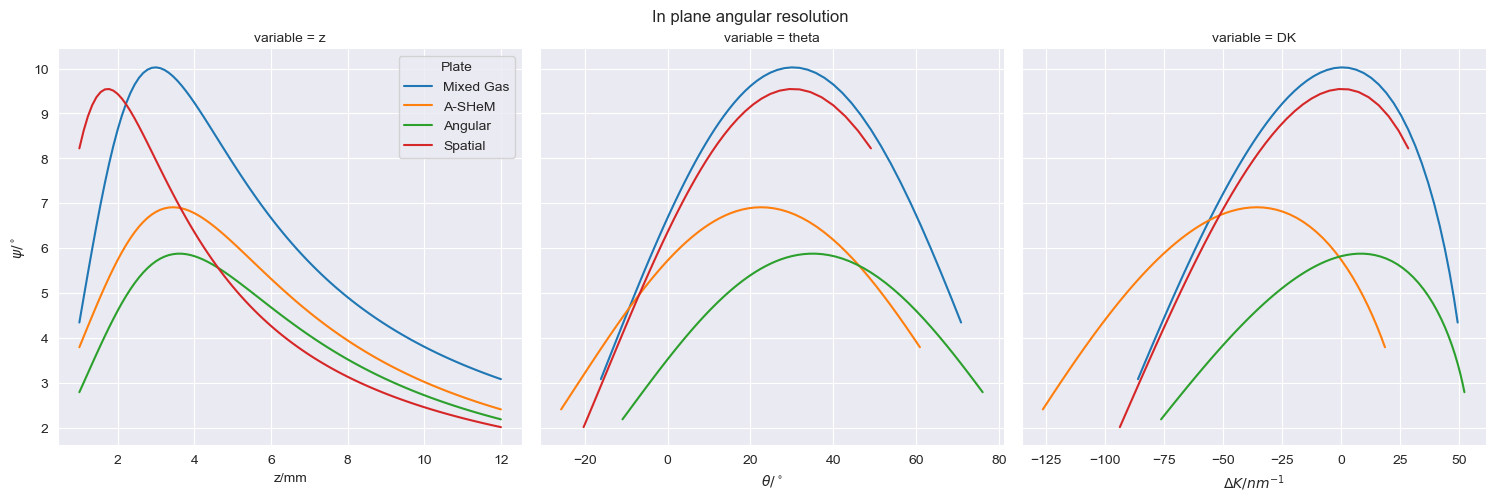

In [5]:
plates2 = pd.melt(plates, id_vars=['Plate', 'psi_ip', 'psi_op', 'omega'], value_vars=['z', 'theta', 'DK'])
g = sns.relplot(
    data = plates2, x='value', y='psi_ip',
    col='variable', hue='Plate', kind='line', 
    col_wrap=3,
    facet_kws=dict(sharex=False, legend_out=False)
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('In plane angular resolution')
g.set_axis_labels("", "$\psi/^\circ$")
g.axes[0].set_xlabel('z/mm')
g.axes[1].set_xlabel('$\\theta/^\circ$')
g.axes[2].set_xlabel('$\Delta K/nm^{-1}$')
plt.savefig('In_plane_angular_resolution.png')

## Out of plane angular resolution

The out of plane angular resolution is also important, we don't want two azimuthally adjacent peaks to overlap.

e:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


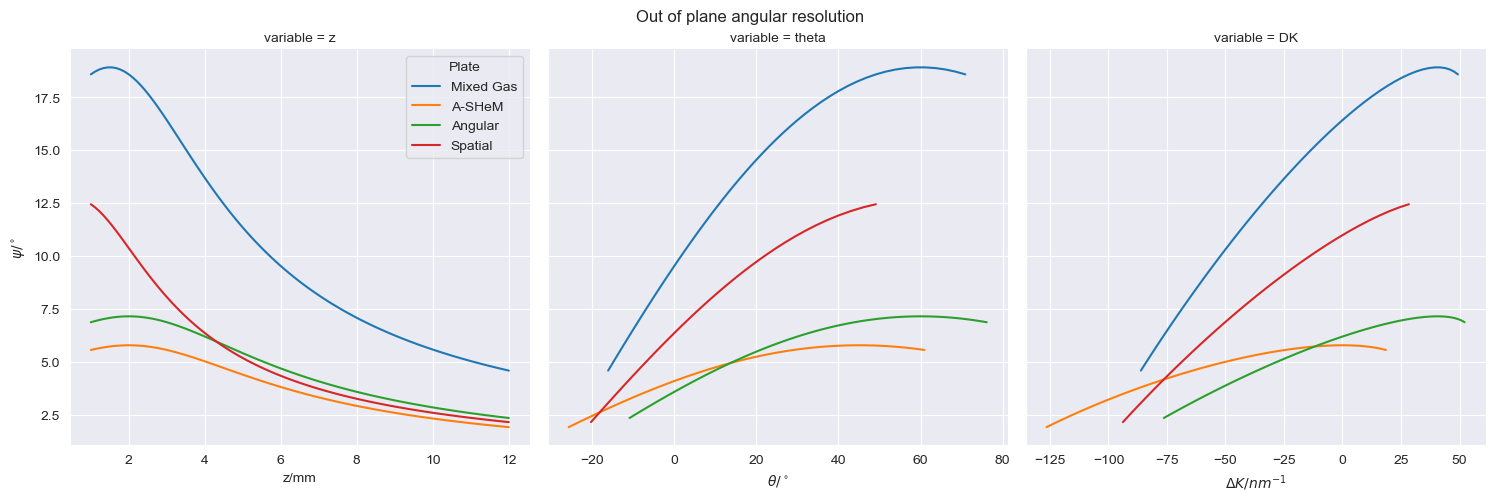

In [6]:
plates2 = pd.melt(plates, id_vars=['Plate', 'psi_ip', 'psi_op', 'omega'], value_vars=['z', 'theta', 'DK'])
g = sns.relplot(
    data = plates2, x='value', y='psi_op',
    col='variable', hue='Plate', kind='line', 
    col_wrap=3,
    facet_kws=dict(sharex=False, legend_out=False)
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Out of plane angular resolution')
g.set_axis_labels("", "$\psi/^\circ$")
g.axes[0].set_xlabel('z/mm')
g.axes[1].set_xlabel('$\\theta/^\circ$')
g.axes[2].set_xlabel('$\Delta K/nm^{-1}$')
plt.savefig('Out_of_plane_angular_resolution.png')

## Solid angle

A thrid variable to test is the solid angle of the apertures. This gives an indication of the signal level for a slowly varying scattering distribution.

e:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


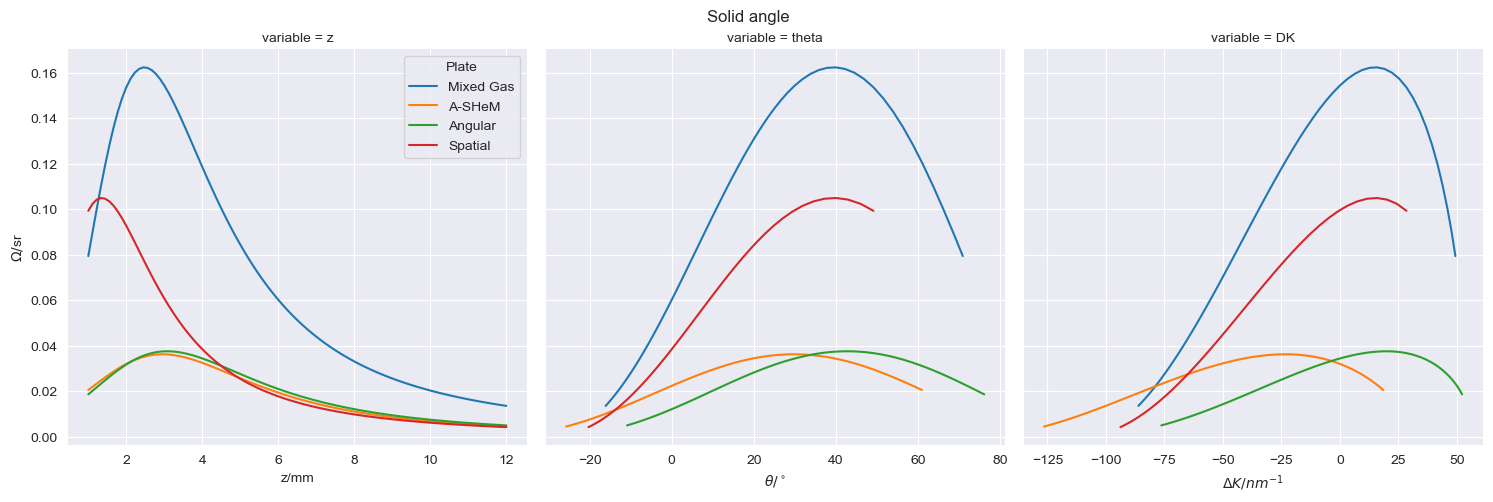

In [7]:
plates2 = pd.melt(plates, id_vars=['Plate', 'psi_ip', 'psi_op', 'omega'], value_vars=['z', 'theta', 'DK'])
g = sns.relplot(
    data = plates2, x='value', y='omega',
    col='variable', hue='Plate', kind='line', 
    col_wrap=3,
    facet_kws=dict(sharex=False, legend_out=False)
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Solid angle')
g.set_axis_labels("", "$\Omega/$sr")
g.axes[0].set_xlabel('z/mm')
g.axes[1].set_xlabel('$\\theta/^\circ$')
g.axes[2].set_xlabel('$\Delta K/nm^{-1}$')
plt.savefig('Solid_angle.png')

## Add diffraction conditions to the plots

One useful way of measuring the effectivness of the pinholplate designs is to look at where the MoS2 diffraction peaks will appear on the plots. We may then also plot the apparent width of those peaks due to the acceptence angle of the detector aperture.

Lattice constant of the Sulfur atoms on MoS2 is 3.2 A.

Text(0.5, 1.0, 'In plane angular resolution')

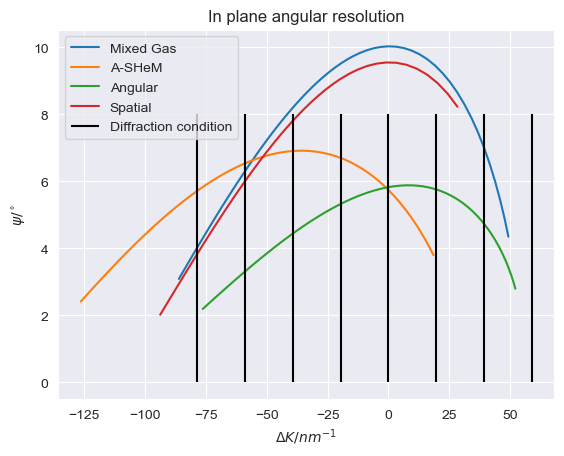

In [8]:
# MoS2 surface lattice constant
mos2_a = 3.2e-10;
G = 2*pi/mos2_a;
order = np.array([-4,-3,-2,-1,0,1,2,3])
# Diffraction peak locations in DK space
DK_peaks = order*G

a = sns.lineplot(plates, x='DK', y='psi_ip', hue='Plate')
a.vlines(DK_peaks*1e-9, ymin=0, ymax=8, color='black', 
         label='Diffraction condition')
a.legend()
a.set_xlabel('$\Delta K/nm^{-1}$')
a.set_ylabel('$\psi/^\circ$')
a.set_title('In plane angular resolution')

Calculate the outgoing angle from the $\Delta K$:
$$
\theta = \arcsin\left(\frac{\Delta K}{k} + \sin\alpha\right).
$$

In [9]:
ki = K # Incident wavenumber
K_surf = ki*np.sin(30*pi/180)
kz = ki*np.cos(30*pi/180)
# Where the peaks will appear as a function of theta for 30deg
# incidence angle
theta_peaks30 = np.arcsin(DK_peaks/ki + np.sin(30*pi/180))*180/pi

# Where the peaks will appear as a function of theta for 45deg
# incidence angle
k_surf = ki*np.sin(45*pi/180)
kz = ki*np.cos(45*pi/180)
theta_peaks45 = np.arcsin(DK_peaks/ki + np.sin(45*pi/180))*180/pi

C:\Users\jerry\AppData\Local\Temp\ipykernel_29680\2854856124.py:6: RuntimeWarning: invalid value encountered in arcsin
  theta_peaks30 = np.arcsin(DK_peaks/ki + np.sin(30*pi/180))*180/pi
C:\Users\jerry\AppData\Local\Temp\ipykernel_29680\2854856124.py:12: RuntimeWarning: invalid value encountered in arcsin
  theta_peaks45 = np.arcsin(DK_peaks/ki + np.sin(45*pi/180))*180/pi


Find the angular accepence at the locations of the diffraction peaks.

[2.19012816 3.31109292 4.4412535  5.3224149  5.82382052 5.75538462
 4.73295789]
[-12.03847489  -1.80089445   8.37872936  18.83584565  30.
  42.62071992  58.68075062          nan]


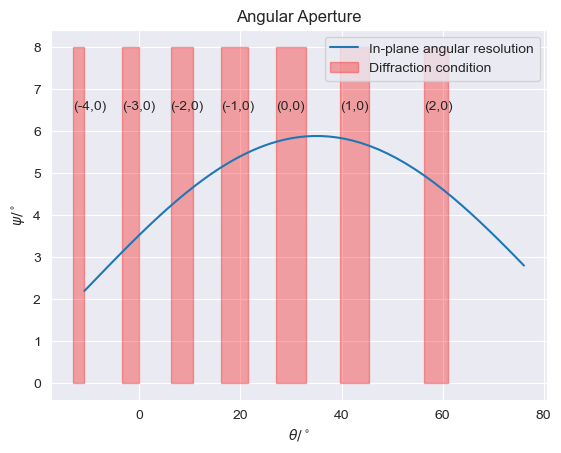

In [10]:
theta = angular['theta']
psi = angular['psi_ip']
widths = np.interp(theta_peaks30[:-1], np.flip(theta), np.flip(psi))

f, ax = plt.subplots()
ax.plot(theta, psi, label='In-plane angular resolution')
for i in range(len(widths)):
    ax.text(theta_peaks30[i]-widths[i]/2, 6.5, '({},0)'.format(i-4))
    if i == 1:
        ax.add_patch(Rectangle([theta_peaks30[i]-widths[i]/2, 0], widths[i], 8,  
                               alpha=0.33, color='red', label='Diffraction condition'))
    else:
        ax.add_patch(Rectangle([theta_peaks30[i]-widths[i]/2, 0], widths[i], 8,  
                               alpha=0.33, color='red'))
ax.legend()
ax.set_xlabel(r'$\theta/^\circ$')
ax.set_ylabel('$\psi/^\circ$')
ax.set_title('Angular Aperture')
print(widths)
print(theta_peaks30)

And for the original A-SHem diffraction pinhole plate. 

array([-0.08374939, 10.11825669, 20.66005174, 32.0030671 , 45.        ,
       62.15923218,         nan,         nan])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


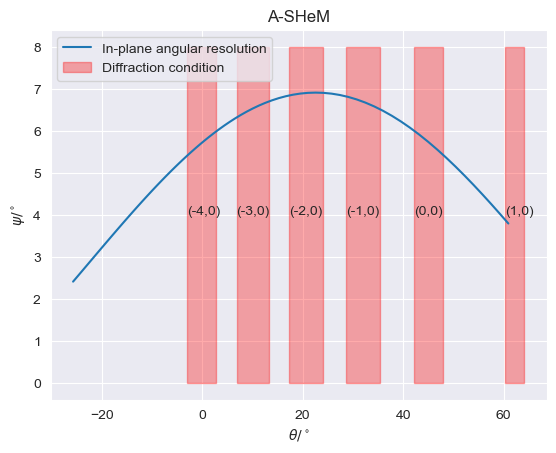

In [11]:
theta = a_shem['theta']
psi = a_shem['psi_ip']
widths = np.interp(theta_peaks45, np.flip(theta), np.flip(psi))

f, ax = plt.subplots()

ax.plot(theta, psi, label='In-plane angular resolution')
for i in range(len(widths)):
    ax.text(theta_peaks45[i]-widths[i]/2, 4, '({},0)'.format(i-4))
    if i == 1:
        ax.add_patch(Rectangle([theta_peaks45[i]-widths[i]/2, 0], widths[i], 8,  
                               alpha=0.33, color='red', label='Diffraction condition'))
    else:
        ax.add_patch(Rectangle([theta_peaks45[i]-widths[i]/2, 0], widths[i], 8,  
                               alpha=0.33, color='red'))
ax.legend(loc='upper left')
ax.set_xlabel(r'$\theta/^\circ$')
ax.set_ylabel('$\psi/^\circ$')
ax.set_title('A-SHeM')
theta_peaks45

For the 'spatial' aperture.

Text(0.5, 1.0, 'Spatial Aperture')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


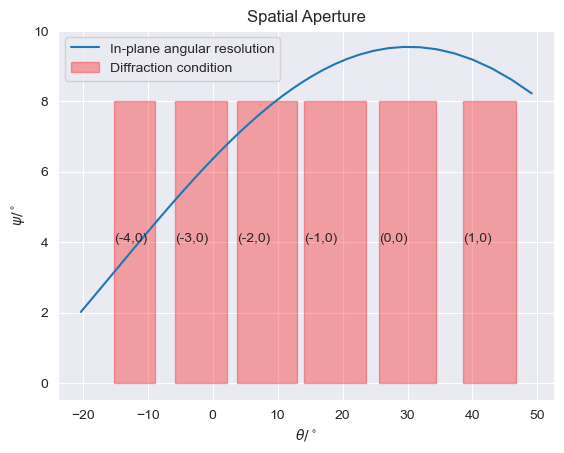

In [12]:
theta = spatial['theta']
psi = spatial['psi_ip']
widths = np.interp(theta_peaks45, np.flip(theta), np.flip(psi))

f, ax = plt.subplots()

ax.plot(theta, psi, label='In-plane angular resolution')
for i in range(len(widths)):
    ax.text(theta_peaks30[i]-widths[i]/2, 4, '({},0)'.format(i-4))
    if i == 1:
        ax.add_patch(Rectangle([theta_peaks30[i]-widths[i]/2, 0], widths[i], 8,  
                               alpha=0.33, color='red', label='Diffraction condition'))
    else:
        ax.add_patch(Rectangle([theta_peaks30[i]-widths[i]/2, 0], widths[i], 8,  
                               alpha=0.33, color='red'))
ax.legend(loc='upper left')
ax.set_xlabel(r'$\theta/^\circ$')
ax.set_ylabel('$\psi/^\circ$')
ax.set_title('Spatial Aperture')


Finally for the Mixed gas pinhole plate.

Text(0.5, 1.0, 'Mixed Gas')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


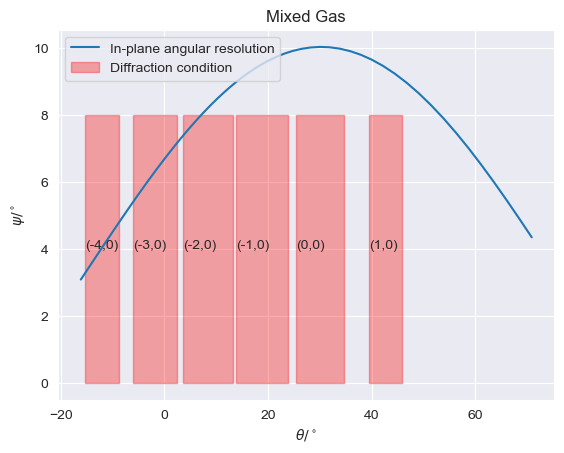

In [13]:
theta = mixed_gas['theta']
psi = mixed_gas['psi_ip']
widths = np.interp(theta_peaks45, np.flip(theta), np.flip(psi))

f, ax = plt.subplots()

ax.plot(theta, psi, label='In-plane angular resolution')
for i in range(len(widths)):
    ax.text(theta_peaks30[i]-widths[i]/2, 4, '({},0)'.format(i-4))
    if i == 1:
        ax.add_patch(Rectangle([theta_peaks30[i]-widths[i]/2, 0], widths[i], 8,  
                               alpha=0.33, color='red', label='Diffraction condition'))
    else:
        ax.add_patch(Rectangle([theta_peaks30[i]-widths[i]/2, 0], widths[i], 8,  
                               alpha=0.33, color='red'))
ax.legend(loc='upper left')
ax.set_xlabel(r'$\theta/^\circ$')
ax.set_ylabel('$\psi/^\circ$')
ax.set_title('Mixed Gas')
